# Fig: Phi

**Motivation**: Dictionary elements. Device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def detect_dead_neurons(tr: TrainerVAE):
    dead_thres = {
        'poisson': 0.008,
        'gaussian': 0.08,
        'laplace': 0.08,
    }
    data, loss, etc = tr.validate()

    if tr.model.cfg.type == 'categorical':
        thres = None
        dead = tr.model.find_dead_neurons(1)
    else:
        thres = dead_thres.get(tr.model.cfg.type)
        dead = loss['kl_diag'] < thres
    return data, loss, etc, thres, dead.astype(bool)

## Fig save dir

In [3]:
from figures.imgs import plot_weights

fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'phi_conv_categorical.png',
    'phi_lca.png',
    'phi_conv_laplace.png',
    'phi_conv_poisson.png',
    'phi_lin_laplace.png',
    'phi_fista.png',
    'phi_conv_gaussian.png',
    'phi_lin_poisson.png',
    'phi_lin_categorical.png',
    'nelbo_point.pdf',
    'phi_lin_gaussian.png'
]

## Device

In [4]:
device_idx = 2
device = f'cuda:{device_idx}'

model_type = 'poisson'

## VAEs

### Linear

In [5]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [6]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 262.7 K

# params: 394.2 K

# params: 394.2 K

[PROGRESS] 'phi_poisson.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

poisson, # dead: 8

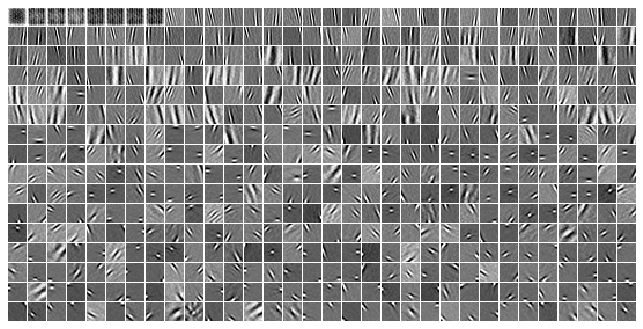

[PROGRESS] 'phi_categorical.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

categorical, # dead: 3

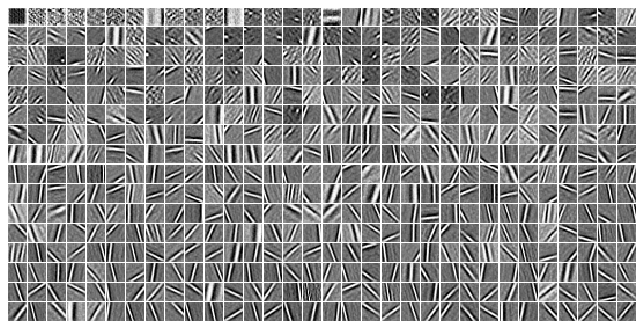

[PROGRESS] 'phi_gaussian.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

gaussian, # dead: 401

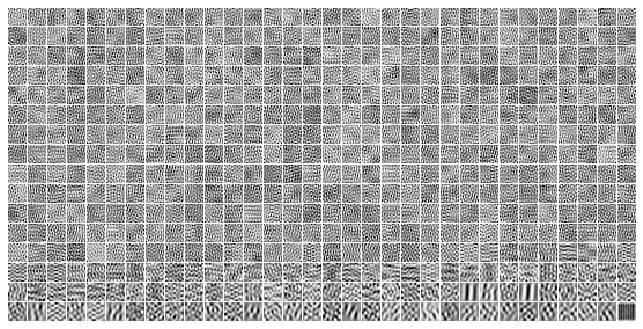

[PROGRESS] 'phi_laplace.npy' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

laplace, # dead: 416

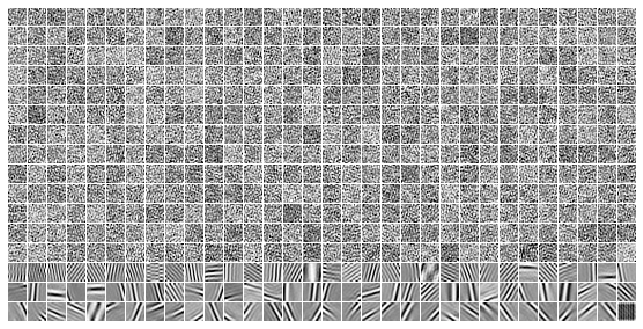

CPU times: user 7.97 s, sys: 650 ms, total: 8.61 s
Wall time: 2.77 s


In [7]:
%%time

for name, tr in trainers.items():
    data, loss, etc, thres, dead = detect_dead_neurons(tr)
    save_obj(
        obj={
            'phi': tonp(tr.model.fc_dec.weight),
            'dead': dead},
        file_name=f"phi_{name}",
        save_dir=tmp_dir,
        verbose=True,
        mode='npy',
    )
    print(f"{name}, # dead: {dead.sum()}")
    
    if tr.model.cfg.type == 'categorical':
        order = etc['logits'].mean(0).ravel()
        order = np.argsort(order)[::-1]
    else:
        order = np.argsort(loss['kl_diag'])
    fig, ax = tr.model.show(order=order, dpi=80) # , figsize=(16, 8))
    # save
    fname = '_'.join([
        'phi',
        tr.model.cfg.enc_type,
        f"{tr.model.cfg.type}.png",
    ])
    fname = pjoin(fig_dir, fname)
    fig.savefig(fname=fname, **kws_fig)

### Conv

In [8]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = ['poisson', 'categorical', 'gaussian', 'laplace']
models2load = {
    name: next(
        f for f in os.listdir(root) if
        f'{name}-<conv+b|lin>-DOVES-mc_solo' in f
    ) for name in models2load
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}
print(models2load)

{
    'poisson': 'poisson-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_14,07:13)',
    'categorical': 'categorical-<conv+b|lin>-DOVES-mc_solo-4_(2024_05_14,06:07)',
    'gaussian': 'gaussian-<conv+b|lin>-DOVES-mc_solo-3_(2024_05_15,02:07)',
    'laplace': 'laplace-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_17,00:00)'
}

In [9]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 1.4 M

# params: 1.4 M

# params: 1.5 M

# params: 1.5 M

poisson, # dead: 76

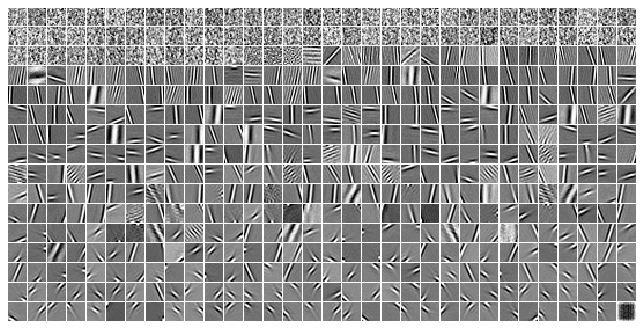

categorical, # dead: 2

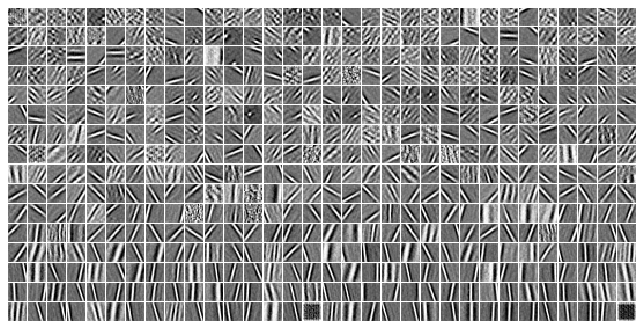

gaussian, # dead: 386

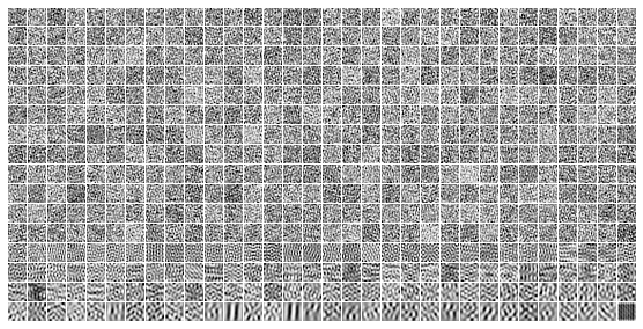

laplace, # dead: 399

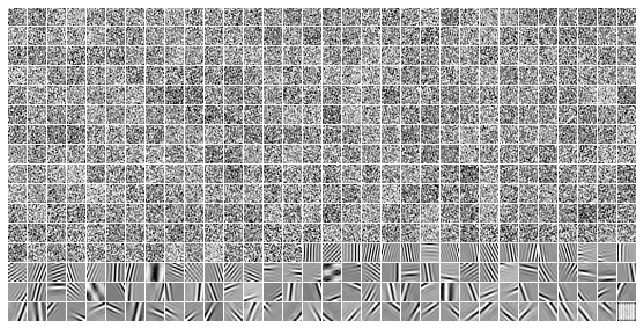

CPU times: user 8.98 s, sys: 593 ms, total: 9.57 s
Wall time: 3.83 s


In [10]:
%%time

for name, tr in trainers.items():
    data, loss, etc = tr.validate()
    dead = tr.find_dead_neurons()
    print(f"{name}, # dead: {dead.sum()}")

    if tr.model.cfg.type == 'categorical':
        order = etc['logits'].mean(0).ravel()
        order = np.argsort(order)[::-1]
    else:
        order = np.argsort(loss['kl_diag'])
    fig, ax = tr.model.show(order=order, dpi=80)
    # save
    fname = '_'.join([
        'phi',
        tr.model.cfg.enc_type,
        f"{tr.model.cfg.type}.png",
    ])
    fname = pjoin(fig_dir, fname)
    fig.savefig(fname=fname, **kws_fig)

## FISTA / LCA

In [8]:
sc_models = {
    'lca': 'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-1',
    'ista': 'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-1',
}

lca

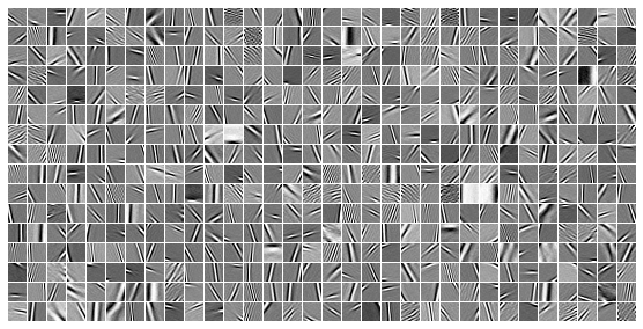

ista

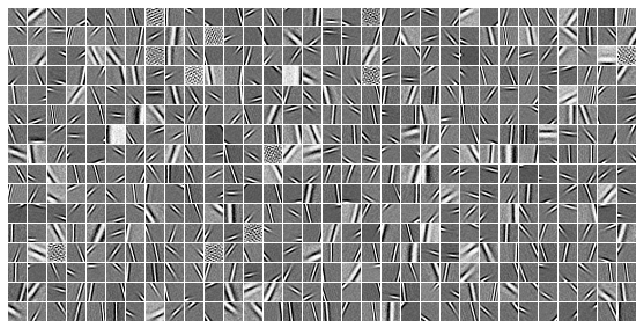

In [9]:
sc_results = {}
for name, fname in sc_models.items():
    root = add_home(f"Dropbox/chkpts/{name.upper()}")
    run = np.load(pjoin(root, f"{fname}.npz"))
    
    y, z, phi = run['recons'], run['activations'], run['dictionary']
    sc_results[name] = (y, z, phi)

    print(name)
    fig, _ = plot_weights(phi.T.reshape(-1, 16, 16), dpi=80)
    plt.show()

    # save
    fname = '_'.join(['phi', f"{name}.png"])
    fname = pjoin(fig_dir, fname)
    fig.savefig(fname=fname, **kws_fig)

In [10]:
y, z, phi = sc_results['lca']

In [17]:
lifetime, population, _ = sparse_score(z.astype('float32'))
lifetime.mean()

0.9170501